# The Oguri Model

NOTE: Remember to clean up code and add comments / reference resources before submission

In this notebook, we will ...

**Learning Objectives**

1. ...

**Import modules**
Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dateutil import parser
import matplotlib.colors as mpl_colors
from sklearn.model_selection import train_test_split

## Japanese Race Horses

Let's read in the data here:

In [2]:
# read in the Japanese Race Horse racing data
df_jp = pd.read_csv('jpracehorses.csv', header=1)

df_jp.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX
0,Special Week,"Dec 26,1999",ARIMA KINEN (GRAND PRIX) G1,NAKAYAMA,TURF,2500M,FIRM,2:37.2,2,0.0,464 (-4),Stallion
1,Special Week,"Nov 28,1999",JAPAN CUP G1,TOKYO,TURF,2400M,FIRM,2:25.5,1,0.2,468 (-2),Stallion
2,Special Week,"Oct 31,1999",TENNO SHO(AUTUMN) G1,TOKYO,TURF,2000M,FIRM,1:58.0,1,0.1,470 (-16),Stallion
3,Special Week,"Oct 10,1999",KYOTO DAISHOTEN G2,KYOTO,TURF,2400M,FIRM,2:25.1,7,0.8,486 (+6),Stallion
4,Special Week,"Jul 11,1999",TAKARAZUKA KINEN G1,HANSHIN,TURF,2200M,FIRM,2:12.6,2,0.5,480 (+4),Stallion


In [3]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.strftime.html
# Data Preprocessing
# Converts string date to datetime format, then converts to Year-Month-Date format
df_jp['DATE'] = pd.to_datetime(df_jp['DATE'], format="%b %d,%Y", errors='coerce')
df_jp['DATE'] = df_jp['DATE'].dt.strftime('%Y-%m-%d')
df_jp['DISTANCE'] = df_jp['DISTANCE'].astype(str).str.replace('M', '')
df_jp['DISTANCE'] = pd.to_numeric(df_jp['DISTANCE'],errors='coerce')
df_jp['FINISHPOSITION'] = pd.to_numeric(df_jp['FINISHPOSITION'],errors='coerce')
#TODO: Convert finish time into all seconds, and to convert from string into float
def convert_time_jp(time):
    # TODO: check for inv. values if needed
    try:
        # for the cases of NaN (some races don't have finish times)
        if pd.isna(time):
            return np.nan
        parts = str(time).split(':')
        if len(parts) == 2:
            # for the cases (ex. 1:30.1)
            mins, secs = int(parts[0]), float(parts[1])
            res = (mins * 60) + secs
        elif len(parts) == 1:
            # for the cases (ex. 95.1)
            res = float(parts[0])
        else:
            return np.nan
        #mins, secs = int(parts[0]), float(parts[1])
        #res = (mins * 60) + secs
    except Exception as e:
        return np.nan
    return res

df_jp['FINISHTIME'] = df_jp['FINISHTIME'].apply(convert_time_jp)
df_jp['MARGIN'] = pd.to_numeric(df_jp['MARGIN'],errors='coerce')
df_jp['WEIGHT'] = df_jp['WEIGHT'].astype(str).str.extract(r'(\d+)').astype(float)

# Converting CONDITIONS to numerical values
conditions_map = {
    # Rank 1 (Fastest, Firmest)
    'FIRM': 1, 'FAST': 1, 'GOOD TO FIRM': 1, 'WF': 1,
    # Rank 2 (Good, Standard)
    'GOOD': 2, 'GD': 2, 'STANDARD': 2,
    # Rank 3 (Slightly Slow, Yielding)
    'YIELD': 3, 'YIELDING': 3, 'GOOD TO YIELDING': 3, 'SLOW': 3, 'WS': 3,
    # Rank 4 (Slowest, Heavy, Adverse)
    'SOFT': 4, 'HEAVY': 4, 'MUDDY': 4, 'SLOPPY': 4, 'POOR': 4, 'SE': 4, 'SLOPPY': 4
}

#unique_names = df_jp['CONDITION'].unique()
#print(unique_names)
df_jp['CONDITION_CLASSIFICATION'] = 0 # TODO: need to add a condition where 0 is invalid or dropped because it corresponds to NaN conditions
df_jp['CONDITION_CLASSIFICATION'] = df_jp['CONDITION'].map(conditions_map).astype(float)

# add a classification column for SEX
sex_map = {'Stallion': 1, 'Mare': 0, 'Gelding': 0}
df_jp['SEX_CLASSIFICATION'] = 1
df_jp['SEX_CLASSIFICATION'] = df_jp['SEX'].map(sex_map).astype(float)

# add a classification column for TRACK
#unique_track = df_jp['TRACK'].unique()
#print(unique_track)
track_map = {
    'TURF': 1, 
    'Turf': 1,
    'AWT': 0, 
    'DIRT': 0,
    'Dirt': 0,
    'JUMP': 0
}
df_jp['TRACK_CLASSIFICATION'] = 1
df_jp['TRACK_CLASSIFICATION'] = df_jp['TRACK'].map(track_map).astype(float)
# get rid of any entry with a NaN value (some horses data could not be fully accessed so they were added with missing race data)
df_jp = df_jp.dropna()

In [4]:
pd.set_option('display.max_rows', None) # this is required to see all of the rows in the dataset.
#display(df_jp)
df_jp.head()
#df_jp.groupby('NAME')['MARGIN'].mean().sort_values(ascending=False)

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX,CONDITION_CLASSIFICATION,SEX_CLASSIFICATION,TRACK_CLASSIFICATION
0,Special Week,1999-12-26,ARIMA KINEN (GRAND PRIX) G1,NAKAYAMA,TURF,2500.0,FIRM,157.2,2.0,0.0,464.0,Stallion,1.0,1.0,1.0
1,Special Week,1999-11-28,JAPAN CUP G1,TOKYO,TURF,2400.0,FIRM,145.5,1.0,0.2,468.0,Stallion,1.0,1.0,1.0
2,Special Week,1999-10-31,TENNO SHO(AUTUMN) G1,TOKYO,TURF,2000.0,FIRM,118.0,1.0,0.1,470.0,Stallion,1.0,1.0,1.0
3,Special Week,1999-10-10,KYOTO DAISHOTEN G2,KYOTO,TURF,2400.0,FIRM,145.1,7.0,0.8,486.0,Stallion,1.0,1.0,1.0
4,Special Week,1999-07-11,TAKARAZUKA KINEN G1,HANSHIN,TURF,2200.0,FIRM,132.6,2.0,0.5,480.0,Stallion,1.0,1.0,1.0


## Hong Kong Race Horses

Let's read in the data here:

In [5]:
# read in the Japanese Race Horse racing data
df_hk = pd.read_csv('hkracehorses.csv', header=1)

df_hk.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX
0,AURORA LADY (J066),11/02/25,149,HAPPY VALLEY,Turf,1200,GOOD TO FIRM,1.09.09,3,1-1/4,124,Stallion
1,AURORA LADY (J066),"Oct 22,2025",119,HAPPY VALLEY,Turf,1000,GOOD,0.56.82,4,3-3/4,130,Stallion
2,AURORA LADY (J066),"Jul 16,2025",846,HAPPY VALLEY,Turf,1200,GOOD TO FIRM,1.08.65,3,3-1/2,119,Stallion
3,AURORA LADY (J066),"Jun 28,2025",794,SHA TIN,Turf,1000,GOOD,0.56.56,6,5-1/2,120,Stallion
4,AURORA LADY (J066),06/04/25,736,HAPPY VALLEY,Turf,1200,GOOD TO YIELDING,1.10.07,6,2-1/2,129,Stallion


In [6]:
df_hk['NAME'] = df_hk['NAME'].str.replace(r'\s*\([^)]*\)', '', regex=True)
# Parser changes all of the date entries to be in the same format, and strftime changes it into year-month-day format
# HK dataset recorded dates in different formats, so could not be cleaned the same way as JP set.
# https://stackoverflow.com/questions/48384376/converting-multiple-date-formats-into-one-format-python
df_hk['DATE'] = df_hk['DATE'].astype(str).map(parser.parse)
df_hk['DATE'] = df_hk['DATE'].dt.strftime('%Y-%m-%d')
df_hk['DISTANCE'] = pd.to_numeric(df_hk['DISTANCE'],errors='coerce').astype(float)
df_hk['FINISHPOSITION'] = pd.to_numeric(df_hk['FINISHPOSITION'],errors='coerce')

def convert_time_hk(time):
    # TODO: check for inv. values if needed
    try:
        parts = str(time).split('.')
        #if len(parts) != 3:
        #    return np.nan
        #mins, secs, centisecs, = int(parts[0]), int(parts[1]), int(parts[2])
        #res = (mins * 60) + secs + (centisecs / 100.0)
        if len(parts) == 3:
            # for the cases of finish times (ex. 1.09.09)
            mins, secs, centisecs, = int(parts[0]), int(parts[1]), int(parts[2])
            res = (mins * 60) + secs + (centisecs / 100.0)
        elif len(parts) == 2:
            # for the cases of finish times (ex. 58.3)
            res = float(parts[0]) + (float(parts[1]) / 100.0)
        else:
            return np.nan
    except ValueError as e:
        print(f"Invalid value '{time}'")
        return np.nan
    return res

def convert_margin_hk(margin):
    # TODO: check for inv. values if needed
    try:
        margin = str(margin)
        if '-' in margin:
            whole, frac = margin.split('-')
            # invalid val
            if '/' not in frac:
                return np.nan
            whole = float(whole)
            num, den = map(int, frac.split('/'))
            return whole + (float(num) / den)
        elif '/' in margin:
            num, den = map(int, margin.split('/'))
            #return whole + (float(num) / den)
            return float(num) / den
        else:
            return float(margin)
    except Exception as e:
        return np.nan

df_hk['FINISHTIME'] = df_hk['FINISHTIME'].apply(convert_time_hk)
df_hk['MARGIN'] = df_hk['MARGIN'].apply(convert_margin_hk)
df_hk['WEIGHT'] = pd.to_numeric(df_hk['WEIGHT'],errors='coerce').astype(float)

#unique_names = df_hk['CONDITION'].unique()
#print(unique_names)
df_hk['CONDITION_CLASSIFICATION'] = 0 # TODO: need to add a condition where 0 is invalid or dropped because it corresponds to NaN conditions
df_hk['CONDITION_CLASSIFICATION'] = df_hk['CONDITION'].map(conditions_map).astype(float)

# add a classification column for SEX
df_hk['SEX_CLASSIFICATION'] = 1
df_hk['SEX_CLASSIFICATION'] = df_hk['SEX'].map(sex_map).astype(float)

#unique_track = df_hk['TRACK'].unique()
#print(unique_track)
# add a classification column for TRACK
df_hk['TRACK_CLASSIFICATION'] = 1
df_hk['TRACK_CLASSIFICATION'] = df_hk['TRACK'].map(track_map).astype(float)

# get rid of any entry with a NaN value (some horses data could not be fully accessed so they were added with missing race data)
df_hk = df_hk.dropna()

In [7]:
df_hk.head()

,NAME,DATE,RACENAME,COURSE,TRACK,DISTANCE,CONDITION,FINISHTIME,FINISHPOSITION,MARGIN,WEIGHT,SEX,CONDITION_CLASSIFICATION,SEX_CLASSIFICATION,TRACK_CLASSIFICATION
0,AURORA LADY,2025-11-02,149,HAPPY VALLEY,Turf,1200.0,GOOD TO FIRM,69.09,3.0,1.25,124.0,Stallion,1.0,1.0,1.0
1,AURORA LADY,2025-10-22,119,HAPPY VALLEY,Turf,1000.0,GOOD,56.82,4.0,3.75,130.0,Stallion,2.0,1.0,1.0
2,AURORA LADY,2025-07-16,846,HAPPY VALLEY,Turf,1200.0,GOOD TO FIRM,68.65,3.0,3.50,119.0,Stallion,1.0,1.0,1.0
3,AURORA LADY,2025-06-28,794,SHA TIN,Turf,1000.0,GOOD,56.56,6.0,5.50,120.0,Stallion,2.0,1.0,1.0
4,AURORA LADY,2025-06-04,736,HAPPY VALLEY,Turf,1200.0,GOOD TO YIELDING,70.07,6.0,2.50,129.0,Stallion,3.0,1.0,1.0


In [8]:
#pd.set_option('display.max_rows', None) # this is required to see all of the rows in the dataset.
#display(df_hk)
#df_hk.head()
#df_hk.groupby('NAME')['FINISHPOSITION'].mean().sort_values(ascending=False)


## Japanese Horses Raw Data Plot

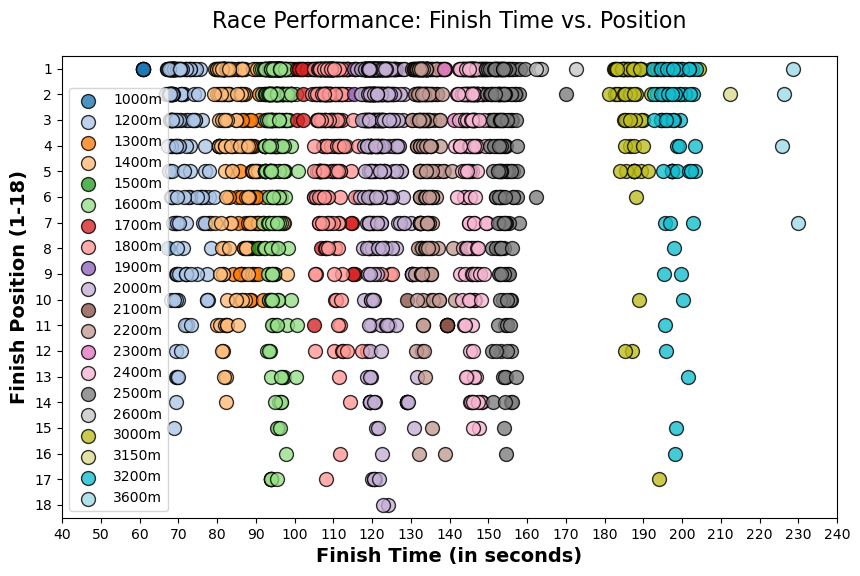

In [9]:
jp_distances = [1000, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3150, 3200, 3600]
jp_xticks = [40, 250, 10]

# Code for raw data plot
def raw_data_plot(distances, df, xticks_vars):
    plt.figure(figsize=(10, 6))
    cmap_base = plt.colormaps.get_cmap('tab20')

    colors = cmap_base(np.linspace(0, 1, len(distances)))

    for i, distance in enumerate(distances):
        df_subset = df[df['DISTANCE'] == distance]

        if not df_subset.empty:
            plt.scatter(df_subset['FINISHTIME'], df_subset['FINISHPOSITION'],
                        c=[colors[i]],
                        edgecolor='black',     # Black border for clarity
                        s=100,                 # Marker size
                        alpha=0.8,             # Transparency
                        label=f'{distance}m')
    plt.legend()
    
    plt.xlabel('Finish Time (in seconds)', fontsize=14, fontweight='bold')
    plt.ylabel('Finish Position (1-18)', fontsize=14, fontweight='bold')
    plt.title('Race Performance: Finish Time vs. Position', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    plt.ylim(18.5, 0.5)
    xticks = plt.xticks(list(range(xticks_vars[0], xticks_vars[1], xticks_vars[2])))
    yticks = plt.yticks(list(range(1, 19)))

raw_data_plot(jp_distances, df_jp, jp_xticks)

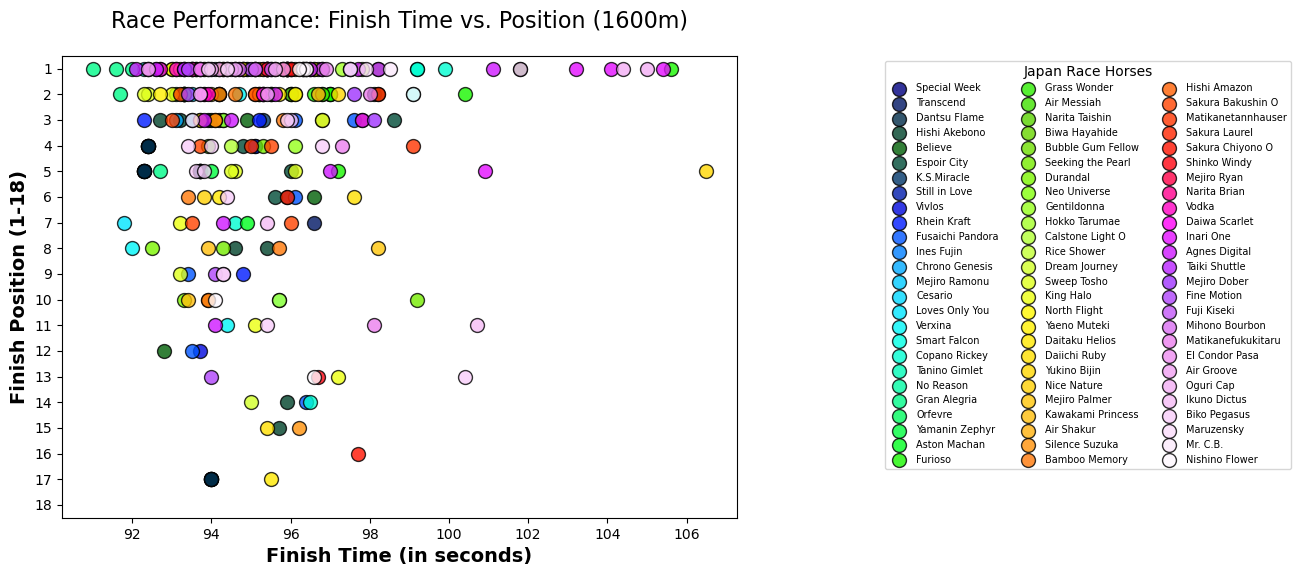

In [10]:
# Code for raw data plot for just distance = 1600
jp_1600_df = df_jp[df_jp['DISTANCE'] == 1600]

def filtered_raw_data_plot(df, df_type):
    unique_horses = df['NAME'].unique()
    num_horses = len(unique_horses)
    
    cmap_base = plt.colormaps.get_cmap('gist_ncar')
    colors = cmap_base(np.linspace(0, 1, num_horses))
    
    plt.figure(figsize=(10, 6))
    for i, horse_name in enumerate(unique_horses):
            df_subset = df[df['NAME'] == horse_name]

            color_index = i % len(colors)

            if not df_subset.empty:
                plt.scatter(df_subset['FINISHTIME'], df_subset['FINISHPOSITION'],
                            c=[colors[color_index]],
                            edgecolor='black',     
                            s=100,               
                            alpha=0.8,           
                            label=horse_name)

    # bbox_to_anchor controls the position of the legend (necessary to get it outside of the plot)
    plt.legend(title=f'{df_type} Race Horses',ncol=3, fontsize=7, bbox_to_anchor=(1.52, 1), loc='upper center')
    # https://www.geeksforgeeks.org/python/matplotlib-pyplot-subplots_adjust-in-python/
    # used to adjust the spacing of the subplots (necessary since the legend is outside of the plot)
    plt.subplots_adjust(right=0.80)
    # color code for individual horses? @andrei
    
    plt.xlabel('Finish Time (in seconds)', fontsize=14, fontweight='bold')
    plt.ylabel('Finish Position (1-18)', fontsize=14, fontweight='bold')
    plt.title('Race Performance: Finish Time vs. Position (1600m)', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    plt.ylim(18.5, 0.5)
    yticks = plt.yticks(list(range(1, 19)))
    plt.show()


filtered_raw_data_plot(jp_1600_df, 'Japan')

## Hong Kong Horses Raw Data Plot

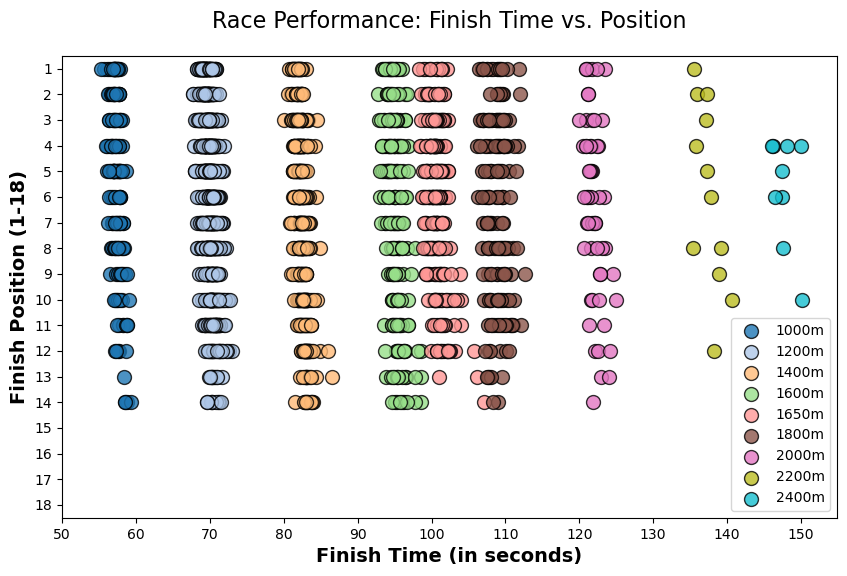

In [11]:
hk_distances = [1000, 1200, 1400, 1600, 1650, 1777, 1800, 2000, 2070, 2200, 2400, 2410]
hk_xticks = [50, 160, 10]

raw_data_plot(hk_distances, df_hk, hk_xticks)

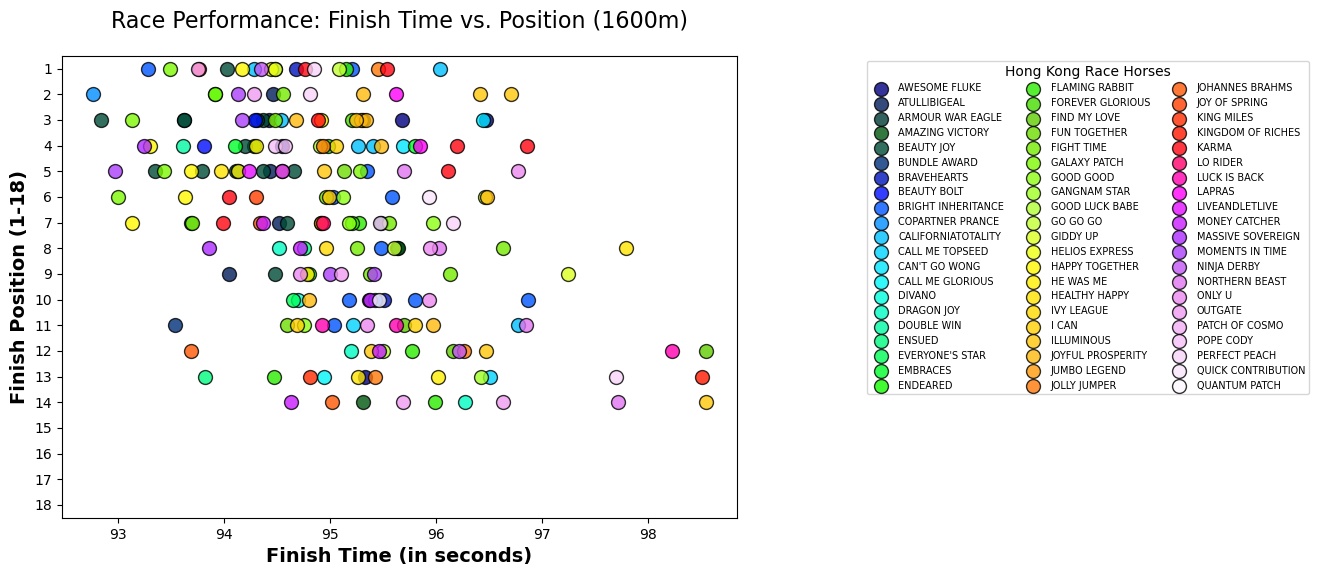

In [12]:
hk_1600_df = df_hk[df_hk['DISTANCE'] == 1600]

filtered_raw_data_plot(hk_1600_df, 'Hong Kong')

Before creating the models, we need to combine the Japan Race Horse and Hong Kong Race Horse data into one dataframe.

In [13]:
# Before combining, we need to go back and assign a 'label' to each JP and HK
# horse to identify them in the combined dataframe
df_jp['REGION'] = 1
df_hk['REGION'] = 0

# Combine the datasets
df_combined = pd.concat([df_jp, df_hk], ignore_index=True)
#display(df_combined)


## Mini Model 1: Predicting Finish Time 

In [14]:
class LinearRegression:
    """
    Linear regression model for predicting continuous outputs.
    """

    def __init__(self, X, learning_rate, n_iterations, random_seed=None):
        """
        Initializes the LinearRegression model and its parameters.

        Parameters
        ----------
        X : np.ndarray
            Input feature matrix used to determine the number of weights.
        learning_rate : float
            Learning rate for gradient descent.
        n_iterations : int
            Number of iterations for training.
        random_seed : int, optional
            Random seed for reproducibility (default is 1).
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        self.initialize(X)
        

    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])
    
    def forward(self, X):
        """
        Computes the predicted output using the current weights.
        """
        y_hat = X@self.w
        return(y_hat)
        

    def loss(self, y, y_hat):
        """
        Computes the mean sum of squared errors loss.
        """
        return (1/np.size(y)) * np.sum((y-y_hat)**2)

    def loss_gradient(self, X, y, y_hat):
        """
        Computes the gradient of the loss with respect to weights.
        """
        return (-2/np.size(y)) * (y-y_hat).T @ X

    #def fit(self, X, y):
    def fit(self, X_train, y_train, X_test, y_test):
        """
        Trains the linear regression model using gradient descent.
        """
        #self.losses = []
        self.train_losses = []
        self.test_losses = []
        for iteration in range(self.n_iterations):
            #y_hat = self.forward(X)
            y_hat_train = self.forward(X_train)
            #gradient = self.loss_gradient(X, y, y_hat)
            gradient = self.loss_gradient(X_train, y_train, y_hat_train)
            self.w -= gradient*self.learning_rate
            self.train_losses.append(self.loss(y_train, y_hat_train))

            y_hat_test = self.forward(X_test)
            self.test_losses.append(self.loss(y_test, y_hat_test))

In [15]:
# Input features: 
# DISTANCE (meters/float value) 
# TRACK (dirt/turf, binary value, need to assign like male/female example in lecture) 
# SEX (stallion/hare, binary value, need to assign like male/female)
# WEIGHT (float)
# CONDITION

def mini_model_1_multiple_linear_regression(df):
    
    feature_variables = ['DISTANCE', 'TRACK_CLASSIFICATION', 'SEX_CLASSIFICATION', 'WEIGHT', 'CONDITION_CLASSIFICATION', 'REGION']
    
    X = df[feature_variables] # independent variables used to predict dependent variable
    y = df['FINISHTIME'] # dependent variable

    # split our data into a training set and testing set
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) # exactly from Lecture 6-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Store the mean and std
    X_train_means = X_train.mean()
    X_train_stds = X_train.std() 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()

    # standardize the features
    X_train_standardized = (X_train - X_train.mean()) / X_train.std()
    X_test_standardized = (X_test - X_train.mean()) / X_train.std()
    y_train_standardized = (y_train - y_train.mean()) / y_train.std()
    y_test_standardized = (y_test - y_train_mean) / y_train_std

    X_train_standardized = X_train_standardized.values
    X_test_standardized = X_test_standardized.values
    y_train_standardized = y_train_standardized.values
    y_test_standardized = y_test_standardized.values

    # create and train multiple linear regression model
    model = LinearRegression(X_train_standardized, learning_rate=0.001, n_iterations=500)
    model.fit(X_train_standardized, y_train_standardized, X_test_standardized, y_test_standardized)

    plot_mini_model_1_losses(model)
    
    # make predictions
    y_train_pred = model.forward(X_train_standardized)
    y_test_pred = model.forward(X_test_standardized)

    # evaluate model
    train_mse = np.mean((y_train.values - y_train_pred)**2)
    test_mse = np.mean((y_test.values - y_test_pred)**2)
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    # Use RMSE instead to account for the high MSE (I believe it happens due to high variation in finish times
    # (short + long distance races are included, which have drastically different finish times)
    # https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # convert the standardized weights back to the original scale
    y_train_pred = y_train_pred * y_train.std() + y_train.mean()
    y_test_pred = y_test_pred * y_train.std() + y_train.mean()

    # from lecture 3-1
    # # convert the standardized weights back to the original scale
    # w1 = w_1_standardized * np.std(y) / np.std(x)
    # w2 = w_2_standardized * np.std(y) / np.std(x**2)
    original_coefs = {}
    for i, feature in enumerate(feature_variables):
        original_coefs[feature] = model.w[i] * (y_train.std() / X_train_stds[feature])
    
    original_intercept = y_train_mean
    for i, feature in enumerate(feature_variables):
        original_intercept -= original_coefs[feature] * X_train_means[feature]

    for feature, coef in original_coefs.items():
        print(f'{feature:30s}: {coef:.6f}')

        plt.figure(figsize=(12, 4))

    # Visualize the results
    plt.subplot(1, 2, 1)
    plt.scatter(y_test.values, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Finish Time (seconds)')
    plt.ylabel('Predicted Finish Time (seconds)')
    plt.title('Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test.values - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Finish Time (seconds)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    #print(X_test.index)

    return {
        'model': model,
        'y_test_pred': y_test_pred,
        'X_test': X_test,
        'X_test_indices': X_test.index,
        'test_mse': test_mse,
        'X_train_means': X_train_means,
        'X_train_stds': X_train_stds,
        'y_train_mean': y_train_mean,
        'y_train_std': y_train_std
    }


def plot_mini_model_1_losses(model):
    plt.figure(figsize=(8, 4))
    plt.plot(model.train_losses, label='Training Loss')
    plt.plot(model.test_losses, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f'Final Training Loss: {model.train_losses[-1]:.6f}')
    print(f'Final Test Loss: {model.test_losses[-1]:.6f}\n')


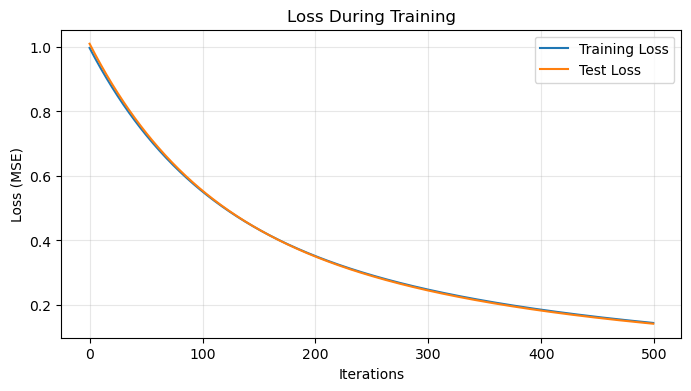

Final Training Loss: 0.144296
Final Test Loss: 0.141897

Training MSE: 11240.27
Test MSE: 11384.31
Training RMSE: 106.02
Test RMSE: 106.70
DISTANCE                      : 0.034340
TRACK_CLASSIFICATION          : 2.859540
SEX_CLASSIFICATION            : 1.796059
WEIGHT                        : 0.028323
CONDITION_CLASSIFICATION      : -0.425391
REGION                        : 8.839574


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

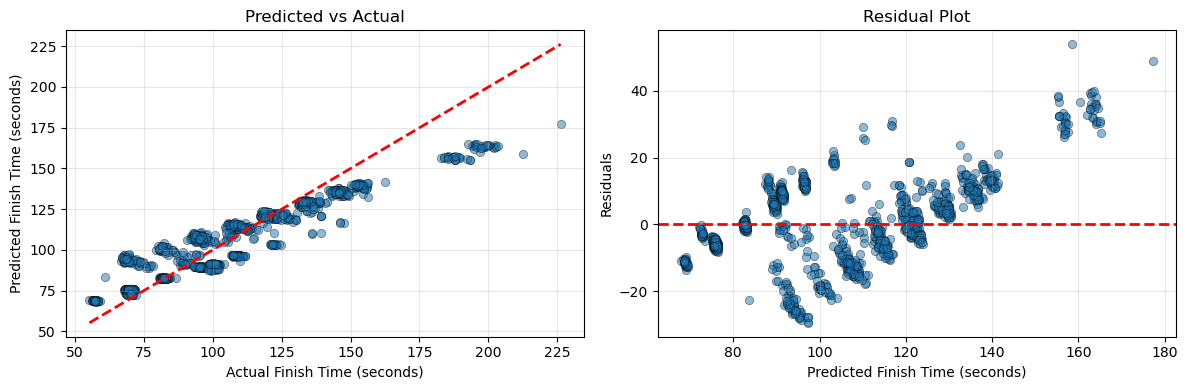

In [16]:
results1 = mini_model_1_multiple_linear_regression(df_combined)

## Mini Model 2: Predicting Margin

In [17]:
# Input features
# PREDICTED FINISH TIME (value from mini model 1)
# DISTANCE (meters/float value)
# SEX (binary)
# WEIGHT (float)

def mini_model_2_multiple_linear_regression(df, model1_results):
    # ask what X_test.index is *******

    # Get the test indices from Model 1
    test_indices = model1_results['X_test_indices']

    feature_variables = ['PREDICTED_FINISH_TIME', 'DISTANCE', 'SEX_CLASSIFICATION', 'WEIGHT']

    X = pd.DataFrame({
        'PREDICTED_FINISH_TIME': model1_results['y_test_pred'],
        'DISTANCE': model1_results['X_test']['DISTANCE'].values,
        'SEX_CLASSIFICATION': model1_results['X_test']['SEX_CLASSIFICATION'].values,
        'WEIGHT': model1_results['X_test']['WEIGHT'].values
    }) # independent variables

    # The margin values from the Model 1 test set
    y = df.loc[test_indices, 'MARGIN'] # dependent variable

    # split our data into a training set and testing set
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) # exactly from Lecture 6-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Store the mean and std
    X_train_means = X_train.mean()
    X_train_stds = X_train.std() 
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()

    # standardize the features
    X_train_standardized = (X_train - X_train.mean()) / X_train.std()
    X_test_standardized = (X_test - X_train.mean()) / X_train.std()
    y_train_standardized = (y_train - y_train.mean()) / y_train.std()
    y_test_standardized = (y_test - y_train_mean) / y_train_std

    X_train_standardized = X_train_standardized.values
    X_test_standardized = X_test_standardized.values
    y_train_standardized = y_train_standardized.values
    y_test_standardized = y_test_standardized.values

    # create and train multiple linear regression model
    model = LinearRegression(X_train_standardized, learning_rate=0.001, n_iterations=500)
    model.fit(X_train_standardized, y_train_standardized, X_test_standardized, y_test_standardized)

    plot_mini_model_2_losses(model)

    # make predictions
    y_train_pred = model.forward(X_train_standardized)
    y_test_pred = model.forward(X_test_standardized)

    # evaluate model
    train_mse = np.mean((y_train.values - y_train_pred)**2)
    test_mse = np.mean((y_test.values - y_test_pred)**2)
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    # Use RMSE instead to account for the high MSE (I believe it happens due to high variation in finish times
    # (short + long distance races are included, which have drastically different finish times)
    # https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # from lecture 3-1
    # # convert the standardized weights back to the original scale
    # w1 = w_1_standardized * np.std(y) / np.std(x)
    # w2 = w_2_standardized * np.std(y) / np.std(x**2)
    original_coefs = {}
    for i, feature in enumerate(feature_variables):
        original_coefs[feature] = model.w[i] * (y_train.std() / X_train_stds[feature])
    
    original_intercept = y_train_mean
    for i, feature in enumerate(feature_variables):
        original_intercept -= original_coefs[feature] * X_train_means[feature]

    for feature, coef in original_coefs.items():
        print(f'{feature:30s}: {coef:.6f}')

        plt.figure(figsize=(12, 4))


    # Visualize the results
    plt.subplot(1, 2, 1)
    plt.scatter(y_test.values, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlim(-1, 15)
    plt.ylim(-1, 15)
    plt.xlabel('Actual Margin')
    plt.ylabel('Predicted Margin')
    plt.title('Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y_test.values - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Margin')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    #print(X_test.index)

    return {
        'model': model,
        'y_test_pred': y_test_pred,
        'X_test': X_test,
        'X_test_indices': X_test.index,
        'test_mse': test_mse,
        'X_train_means': X_train_means,
        'X_train_stds': X_train_stds,
        'y_train_mean': y_train_mean,
        'y_train_std': y_train_std
    }

def plot_mini_model_2_losses(model):
    plt.figure(figsize=(8, 4))
    plt.plot(model.train_losses, label='Training Loss')
    plt.plot(model.test_losses, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss During Training')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    print(f'Final Training Loss: {model.train_losses[-1]:.6f}')
    print(f'Final Test Loss: {model.test_losses[-1]:.6f}\n')
    

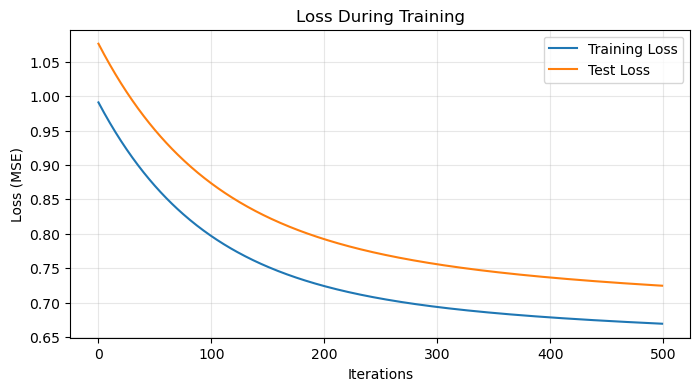

Final Training Loss: 0.669468
Final Test Loss: 0.724664

Training MSE: 12.48
Test MSE: 13.35
Training RMSE: 3.53
Test RMSE: 3.65
PREDICTED_FINISH_TIME         : -0.020753
DISTANCE                      : -0.000424
SEX_CLASSIFICATION            : 0.702506
WEIGHT                        : -0.004225


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

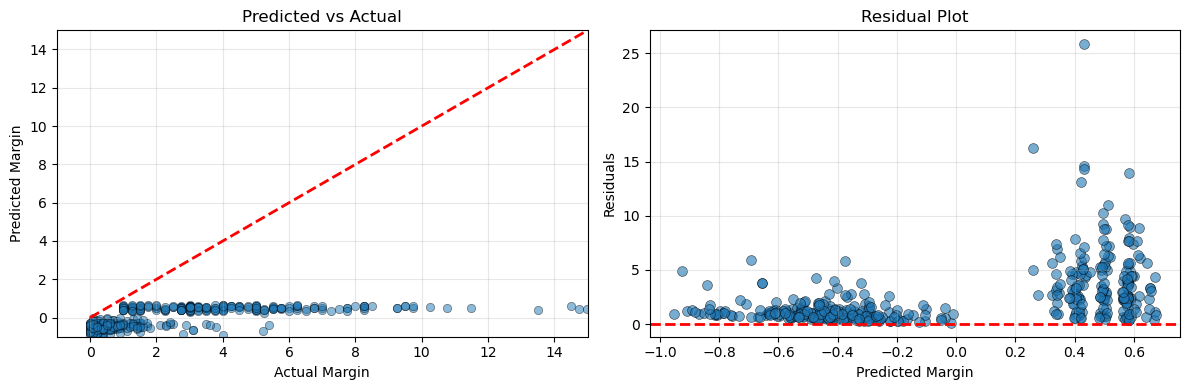

In [18]:
results2 = mini_model_2_multiple_linear_regression(df_combined, results1)

*** need to see if it is possible to have instead actual vs predicted be x and y axis, it should be two separate lines on the same graph

## Main Model: Predicting win/loss probability

In [19]:
class LogisticRegression:
    def __init__(self, X, learning_rate=0.001, n_iters=1000, random_seed=None):
        """
        Parameters:
        - X: Training data matrix (num_samples x num_features)
        - learning_rate: Step size for weight updates
        - n_iters: Number of training iterations
        - random_seed: Seed for reproducibility
        """
        self.lr = learning_rate
        self.n_iters = n_iters
        self.random_seed = random_seed
        self.initialize(X)
        
    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])

    def activation(self, x):
        """Binary step activation function"""
        return np.where(x >= 0.5, 1, 0)
        
    def sigmoid(self,x):
        """Sigmoid function to map values to range 0-1"""
        # Addresses the issue of the main model plot not showing the colors due to values out of range
        # https://www.geeksforgeeks.org/python/numpy-clip-in-python/#
        # x = np.clip(x, -500, 500)
        sigma = 1/(1+np.exp(-x))
        return sigma

    def predict_probability(self, X):
        """Probability based on linear model and sigmoid transformation"""
        probability = self.sigmoid(np.dot(X, self.w))
        return probability

    def loss(self, p, c):
        """Log-liklihood function multiplied by -1"""
        loss = -np.sum(c * np.log(p + 1e-8) + (1-c)*np.log(1-p + 1e-8))
        return (loss)

    #def fit(self, X, c):
    def fit(self, X_train, c_train, X_test, c_test):
        """Train the logistic regression model"""
        self.train_losses = []
        self.test_losses = []
        for iteration in range(self.n_iters):
            #probability = self.predict_probability(X)
            probability = self.predict_probability(X_train)
            #gradient = np.dot(probability-c, X)
            gradient = np.dot(probability-c_train, X_train)
            self.w -= gradient*self.lr
            #self.losses.append(self.loss(probability, c))
            self.train_losses.append(self.loss(probability, c_train))

            # test loss
            prob_test = self.predict_probability(X_test)
            self.test_losses.append(self.loss(prob_test, c_test))
            
       
    def predict(self, X):
        """Predict binary labels for input data"""
        probability = self.predict_probability(X)
        return self.activation(probability)

In [20]:
# Input features:
# PREDICTED FINISH TIME (value from mini model 1)
# PREDICTED MARGIN (value from mini model 2)
# DISTANCE
# TRACK
# WEIGHT
# 
def main_model_logistic_regression(df, model1_results, model2_results):

    # Get the test indices from Model 2 (only need model 2 because model 1 and 2 use same test indices)
    test_indices_model = model2_results['X_test_indices']

    feature_variables = ['PREDICTED_FINISH_TIME', 'PREDICTED_MARGIN', 'DISTANCE', 'TRACK_CLASSIFICATION', 'WEIGHT']

    X = pd.DataFrame({
        'PREDICTED_FINISH_TIME': model2_results['X_test']['PREDICTED_FINISH_TIME'].values,
        'PREDICTED_MARGIN': model2_results['y_test_pred'],
        'DISTANCE': model2_results['X_test']['DISTANCE'].values,
        'TRACK_CLASSIFICATION': df.loc[test_indices_model, 'TRACK_CLASSIFICATION'].values,
        'WEIGHT': model2_results['X_test']['WEIGHT'].values
    })

    y = (df.loc[test_indices_model, 'FINISHPOSITION'] == 1).astype(int)

    # split our data into a training set and testing set
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17) # exactly from Lecture 6-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Store the mean and std
    X_train_means = X_train.mean()
    X_train_stds = X_train.std() 
    #y_train_mean = y_train.mean()
    #y_train_std = y_train.std()

    # standardize the features
    X_train_standardized = (X_train - X_train.mean()) / X_train.std()
    X_test_standardized = (X_test - X_train.mean()) / X_train.std()
    #y_train_standardized = (y_train - y_train.mean()) / y_train.std()
    #y_test_standardized = (y_test - y_train_mean) / y_train_std

    X_train_standardized = X_train_standardized.values
    X_test_standardized = X_test_standardized.values
    #y_train_standardized = y_train_standardized.values
    #y_test_standardized = y_test_standardized.values
    #y_train = y_train.values
    #y_test = y_test.values

    # create and train multiple linear regression model
    model = LogisticRegression(X_train_standardized, learning_rate=0.001, n_iters=500)
    model.fit(X_train_standardized, y_train, X_test_standardized, y_test)

    plot_main_model_losses(model)

    # Make predictions
    y_train_pred = model.predict(X_train_standardized)
    y_test_pred = model.predict(X_test_standardized)
    
    # evaluate model
    train_mse = np.mean((y_train.values - y_train_pred)**2)
    test_mse = np.mean((y_test.values - y_test_pred)**2)
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    # Use RMSE instead to account for the high MSE (I believe it happens due to high variation in finish times
    # (short + long distance races are included, which have drastically different finish times)
    # https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')

    # Compute the classification accuracy (reference HW2, accuracy instead of loss)
    train_accuracy = np.sum(y_train_pred == y_train) / len(y_train)
    test_accuracy = np.sum(y_test_pred == y_test) / len(y_test)
    print(f'Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
    print(f'Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')

    plot_main_model(model, X_train_means, X_train_stds, 
                                   X_test, y_test, classifications_model=y_test_pred)

    return {
        'model': model,
        'X_train_stds': X_train_stds,
        'X_train_means': X_train_means,
        'test_accuracy': test_accuracy
    }


In [21]:
def plot_main_model_losses(model):
    plt.figure(figsize=(8, 4))
    plt.plot(model.train_losses, label='Training Loss')
    plt.plot(model.test_losses, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Log-Likelihood)')
    plt.title('Loss During Training - Logistic Regression')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f'Final Training Loss: {model.train_losses[-1]:.6f}')
    print(f'Final Test Loss: {model.test_losses[-1]:.6f}\n')

In [22]:
# Taken directly from Lecture 4-1

def plot_main_model(model, X_train_means, X_train_stds, X_test, y_test, classifications_model):
   
    # Define min/max for the two features we want to visualize
    # (Similar to min_x, max_x in lecture but for our features)
    min_finish_time = X_test['PREDICTED_FINISH_TIME'].min() - 10
    max_finish_time = X_test['PREDICTED_FINISH_TIME'].max() + 10
    min_margin = X_test['PREDICTED_MARGIN'].min() - 1
    max_margin = X_test['PREDICTED_MARGIN'].max() + 1
    
    # compute probabilities for a range of values (from lec 4-1)
    x1_data_span = np.linspace(min_finish_time, max_finish_time, 500)
    x2_data_span = np.linspace(min_margin, max_margin, 500)
    X1_data_span, X2_data_span = np.meshgrid(x1_data_span, x2_data_span)
    
    # Create feature matrix for mesh
    # like X_2 = np.column_stack(...) from lec 4-1
    X_2 = pd.DataFrame({
        'PREDICTED_FINISH_TIME': X1_data_span.ravel(),
        'PREDICTED_MARGIN': X2_data_span.ravel(),
        'DISTANCE': np.full(np.size(X1_data_span), X_test['DISTANCE'].mean()),
        'TRACK_CLASSIFICATION': np.full(np.size(X1_data_span), X_test['TRACK_CLASSIFICATION'].mean()),
        'WEIGHT': np.full(np.size(X1_data_span), X_test['WEIGHT'].mean())
    })

    # Standardize X_2
    #X_2_standardized = (X_2 - X_train_means) / X_train_stds

    P = model.predict_probability(X_2.values)
    P = P.reshape(np.shape(X1_data_span))
    
    # make a figure
    plt.figure(figsize=(11, 4))
    
    # make a plot of the data and the model probabilities
    plt.subplot(1, 2, 1)
    # Lost vs Won plot instead of the Male vs Female from lec 4-1
    plt.plot(X_test['PREDICTED_FINISH_TIME'][classifications_model == 0],
             X_test['PREDICTED_MARGIN'][classifications_model == 0],
             'b.', label='Class 0 (Lost)', markersize=8)
    plt.plot(X_test['PREDICTED_FINISH_TIME'][classifications_model == 1],
             X_test['PREDICTED_MARGIN'][classifications_model == 1],
             'r.', label='Class 1 (Won)', markersize=8)
    C = plt.pcolormesh(X1_data_span, X2_data_span, P, cmap='coolwarm', alpha=0.5)
    plt.contour(X1_data_span, X2_data_span, P, levels=[0.5], colors='white', linewidths=2)
    plt.colorbar(C, label='Probability of Winning')
    # axis limits
    plt.gca().set_xlim([min_finish_time, max_finish_time])
    plt.gca().set_ylim([min_margin, max_margin])
    
    plt.xlabel('Predicted Finish Time (seconds)', fontsize=12)
    plt.ylabel('Predicted Margin (lengths)', fontsize=12)
    plt.legend(loc=2)
    plt.title('Modeled Classifications')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

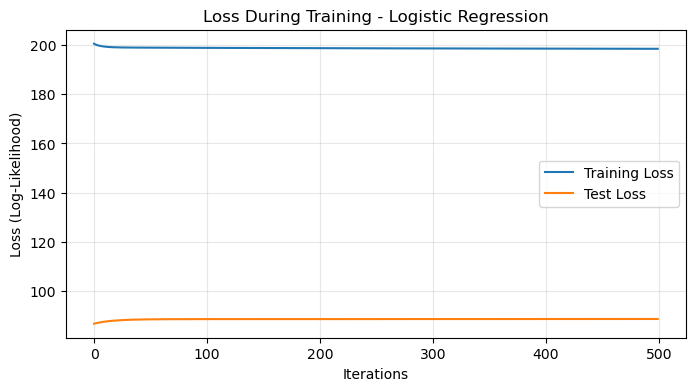

Final Training Loss: 198.473199
Final Test Loss: 88.622336

Training MSE: 0.42
Test MSE: 0.46
Training RMSE: 0.65
Test RMSE: 0.68
Training Accuracy: 0.5779 (57.79%)
Test Accuracy: 0.5440 (54.40%)


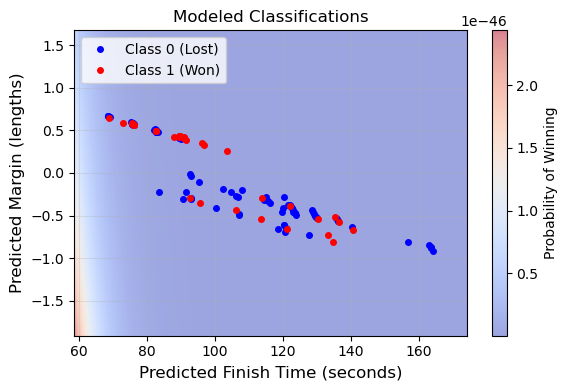

In [23]:
results3 = main_model_logistic_regression(df_combined, results1, results2)

Perfect note to bring up during presentation: As we can see, the model performed horribly. Why? The model is trying to learn from a dataframe that has widely varying distance races. The varying races has winners who have won with barely any margins and varying finish times. This wide range in results confuses the model, which means the main model's results are no better than guessing.

While the race simulation aspect of the project was primarily meant to be included as a fun factor, it could potentially be used to improve the accuracy of the model. In the race simulation, the dataframe that will be trained on will be filtered by race distances. This means that the training and testing data will consist of similar races and horses who excel at these distances. Excluding races and horses that will inevitably negatively influence the predicted finish times and margins will hopefully yield better looking results.

## Race Simulation

In [24]:
def race_simulation(df_combined):

    # As mentioned before, the model struggles when trying to learn from varying races, so the training/testing data
    # will consist of races from similar distances (SPRINTS, MILES, MEDIUM, LONG)
    # Distances that overlap between both datasets (1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400)
    # SPRINTS: < 1600, MILE < 2000, MEDIUM < 2400, LONG > 2400
    distance_category = {
        # SPRINTS
        1000: 'SPRINT', 1200: 'SPRINT', 1400: 'SPRINT',
        # MILE
        1600: 'MILE', 1800: 'MILE',
        # MEDIUM
        2000: 'MEDIUM', 2200: 'MEDIUM',
        # LONG
        2400: 'LONG'
    }
    df_combined['DISTANCE_CATEGORY'] = 'tbd' 
    df_combined['DISTANCE_CATEGORY'] = df_combined['DISTANCE'].map(distance_category)

    # Randomly select a race from either dataset (using only JP, since the names of HK isn't available) and take DISTANCE, TRACK, RACENAME
    df_jp_races = df_combined[df_combined['REGION'] == 1]
    selected_race = df_jp_races.sample(1).iloc[0]

    race_category = selected_race['DISTANCE_CATEGORY']
    race_distance = selected_race['DISTANCE']
    race_track = selected_race['TRACK_CLASSIFICATION']
    race_name = selected_race['RACENAME']

    print(f"\nSelected Race: {race_name}")
    print(f"Distance: {race_distance} m")
    print(f"Category: {race_category}")
    print(f"Track: {'Turf' if race_track==1 else 'Dirt'}")

    # create df_filtered which has the same distance category of the selected race
    df_filtered = df_combined[df_combined['DISTANCE_CATEGORY'] == race_category]
    # fixes the indices
    df_filtered = df_filtered.reset_index(drop=True)
    
    # run model1, model2, main model using the appropriate features from the selected race
    results1 = mini_model_1_multiple_linear_regression(df_filtered)
    results2 = mini_model_2_multiple_linear_regression(df_filtered, results1)
    results3 = main_model_logistic_regression(df_filtered, results1, results2)
    
    # Randomly select 9 horses from each region that have races(predicting results)
    df_jp_pool = df_filtered[df_filtered['REGION'] == 1]
    df_hk_pool = df_filtered[df_filtered['REGION'] == 0]

    jp_horses = df_jp_pool.sample(min(9, len(df_jp_pool)))
    hk_horses = df_hk_pool.sample(min(9, len(df_hk_pool)))

    # fixes the indices
    race_horses = pd.concat([jp_horses, hk_horses]).reset_index(drop=True)

    # Prepare features for Model 1
    X_model1 = race_horses[['DISTANCE', 'TRACK_CLASSIFICATION', 'SEX_CLASSIFICATION', 
                            'WEIGHT', 'CONDITION_CLASSIFICATION', 'REGION']]

    # Standardize using Model 1's training stats
    X_model1_standardized = (X_model1 - results1['X_train_means']) / results1['X_train_stds']

    # Get finish time predictions from Model 1
    predicted_finish_times = results1['model'].forward(X_model1_standardized.values)
    # Destandardize
    predicted_finish_times = predicted_finish_times * results1['y_train_std'] + results1['y_train_mean']
    
    # Prepare features for Model 2
    X_model2 = pd.DataFrame({
        'PREDICTED_FINISH_TIME': predicted_finish_times,
        'DISTANCE': race_horses['DISTANCE'].values,
        'SEX_CLASSIFICATION': race_horses['SEX_CLASSIFICATION'].values,
        'WEIGHT': race_horses['WEIGHT'].values
    })
    
    # Standardize using Model 2's training stats
    X_model2_standardized = (X_model2 - results2['X_train_means']) / results2['X_train_stds']
    
    # Get margin predictions from Model 2
    predicted_margins = results2['model'].forward(X_model2_standardized.values)
    # Destandardize
    predicted_margins = predicted_margins * results2['y_train_std'] + results2['y_train_mean']
    
    # Add predictions to race_horses dataframe
    race_horses['PREDICTED_FINISH_TIME'] = predicted_finish_times
    race_horses['PREDICTED_MARGIN'] = predicted_margins
    
    # get the probability of each of the 18 horses
    probabilities = []
    for index, horse in race_horses.iterrows():
        # Raw feature vector for current horse
        x_raw = np.array([
            horse['PREDICTED_FINISH_TIME'],
            horse['PREDICTED_MARGIN'],
            horse['DISTANCE'],
            horse['TRACK_CLASSIFICATION'],
            horse['WEIGHT']
        ], dtype=float)
        
        # Normalize using training mean/std
        x_norm = (x_raw - results3['X_train_means']) / results3['X_train_stds']

        # Lecture-style prediction
        prob = results3['model'].predict_probability(x_norm)

        probabilities.append(prob)

    race_horses['WIN_PROBABILITY'] = probabilities
    
    # return/ print a list of the results (in order of probability) (higher probability means higher on the podium)
    race_results = race_horses.sort_values('WIN_PROBABILITY', ascending=False)
    #print(race_results[['NAME', 'REGION', 'WIN_PROBABILITY']])

    return race_results[['NAME', 'REGION', 'WIN_PROBABILITY']]


Selected Race: TEIO SHO L
Distance: 2000.0 m
Category: MEDIUM
Track: Dirt


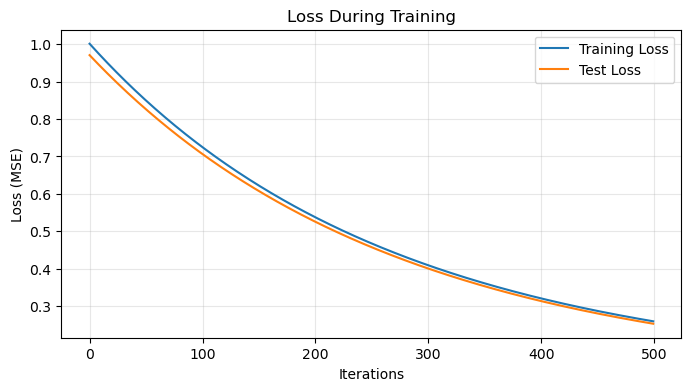

Final Training Loss: 0.259558
Final Test Loss: 0.253080

Training MSE: 15773.65
Test MSE: 15722.50
Training RMSE: 125.59
Test RMSE: 125.39
DISTANCE                      : 0.039024
TRACK_CLASSIFICATION          : -0.989856
SEX_CLASSIFICATION            : -0.110460
WEIGHT                        : 0.000916
CONDITION_CLASSIFICATION      : 0.505788
REGION                        : 0.071769


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

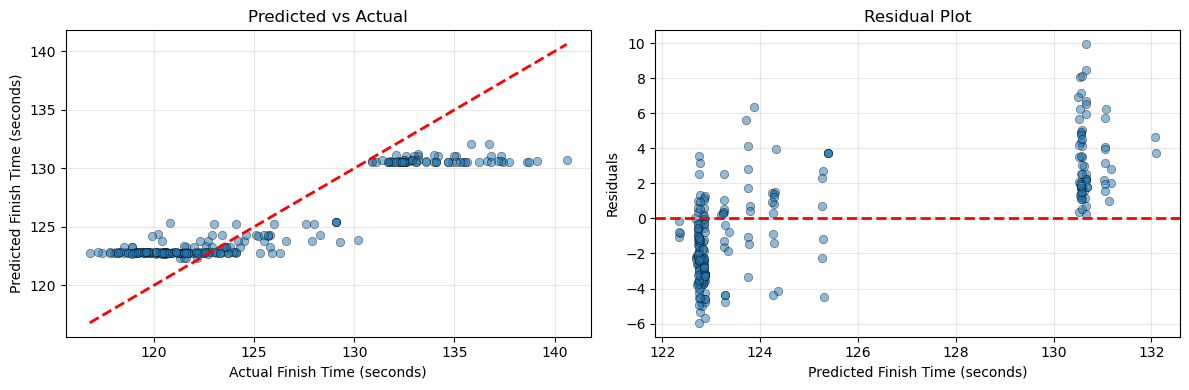

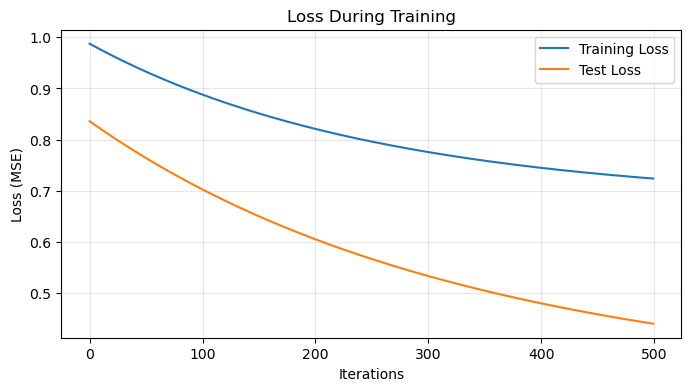

Final Training Loss: 0.723983
Final Test Loss: 0.440522

Training MSE: 4.11
Test MSE: 3.27
Training RMSE: 2.03
Test RMSE: 1.81
PREDICTED_FINISH_TIME         : 0.026679
DISTANCE                      : -0.000021
SEX_CLASSIFICATION            : -0.059119
WEIGHT                        : -0.006862


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

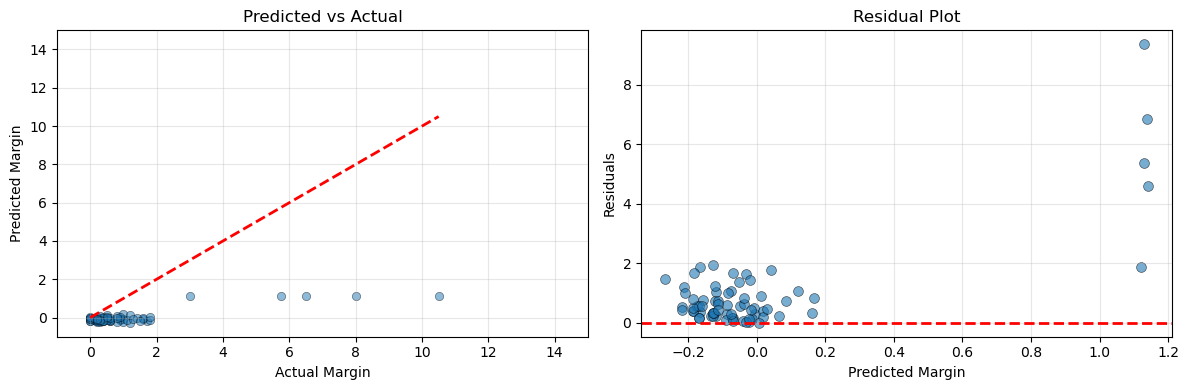

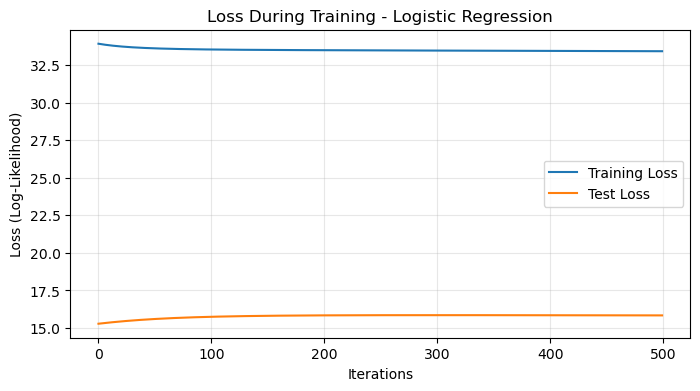

Final Training Loss: 33.434033
Final Test Loss: 15.836068

Training MSE: 0.41
Test MSE: 0.50
Training RMSE: 0.64
Test RMSE: 0.71
Training Accuracy: 0.5918 (59.18%)
Test Accuracy: 0.5000 (50.00%)


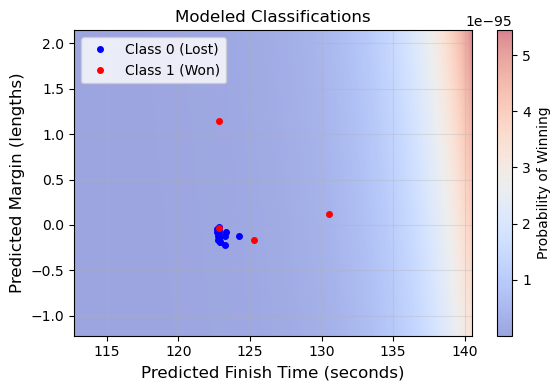

,NAME,REGION,WIN_PROBABILITY
9,GOOD GOOD,0,0.865137
10,NOISY BOY,0,0.865137
13,GO GO GO,0,0.863278
15,MASSIVE SOVEREIGN,0,0.820860
16,CALIFORNIATOTALITY,0,0.819015
17,BRAVEHEARTS,0,0.816654
11,HAPPY TOGETHER,0,0.815465
12,ENSUED,0,0.815465
14,ILLUMINOUS,0,0.814270
7,Chrono Genesis,1,0.634755


In [25]:
race_simulation(df_combined)